<a href="https://colab.research.google.com/github/OConnorsphysics/Data_Science_Machine_Learning/blob/main/Liams_Project2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color= 'lightblue'>**Identifying Location Class from Aerial Imagery** </font>


<img src='http://drive.google.com/uc?export=view&id=1Fo2x1i7BvwMI2vPrQoQyl2Ks6mhcC1ta' width=500>

In this notebook we will be building varying neural networks to predict ground structures and vegetation using aerial imagery. Aerial scene classification is a large field of study within remote sensing, which requires large, diverse datasets. As more high quality satelitte imagery becomes publicly accesible there is a drive to build accurate models to predict, sort, and map ground targets. The ultimate question this leads to is:

**Given any sattelite image, regardless of season, or time of day, can we use a neural network to accurately predict what we have imaged?**

The dataset we will use in our model was compiled by Gui-Song Xia, Jingwen Hu, Fan Hu, Baoguang Shi, Xiang Bai, Yanfei Zhong, and Liangpei Zhang. These researchers co-authored a paper titled "AID: A Benchmark Dataset for Performance Evaluation of Aerial Scene Classification". The data set consists of 10 000 RGB images, that fall into 30 labelled classifications. The images are gathered from Google earth imagery, which uses multiple sensors for collection. The data set has high intra-class diversity as images were taken during different seasons, times of the day, and under varying lighting conditions. The majority of the photos are from China, the United States, England, France, Italy, Japan, Germany.

We will build both a dense and convolutional neural network in hopes of accurately classifying the scenes. To compare the different models we will train them both on the same 80% of the dataset. We will withhold 20% for testing and validation of the models. 


In [ ]:
#load required packages
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

###<font color= 'lightblue'>**Importing Data & Preprocessing** </font>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/AerialImageDataset.zip

## <font color='darkorange'>Preprocessing images</font>

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders # import splitfolders to automate the folder test/train splitting
input_folder = "/content/AID"
output = "/content/split_data" 
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1))

Copying files: 10000 files [00:22, 443.30 files/s]


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib, os

#Set the path to the images
new_base_dir = pathlib.Path("/content/split_data")

In [ ]:
#Training data
train_dataset = image_dataset_from_directory(
            new_base_dir / "train",
            image_size=(180, 180),
            batch_size=40)

Found 8000 files belonging to 30 classes.


In [ ]:
#validation data
validation_dataset = image_dataset_from_directory(
            new_base_dir / "val",
            image_size=(180, 180),
            batch_size=40)



Found 1000 files belonging to 30 classes.


In [ ]:
#test data
test_dataset = image_dataset_from_directory(
            new_base_dir / "test",
            image_size=(180, 180),
            batch_size=1)

Found 1000 files belonging to 30 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (40, 180, 180, 3)
labels batch shape: (40,)


## <font color='darkorange'>Build a standard CNN</font>



In [ ]:
#define all the layers of the model
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Flatten()(inputs)
x = layers.Rescaling(1.0/255)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dense(50, activation='relu')(x)
#x = layers.Dense(20, activation='relu')(x)
outputs = layers.Dense(30, activation="softmax")(x)

#build the model
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
#set the early stopping and model saving
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="Dense_NN.keras",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5)
]

#fit the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
200/200 [==============================] - 58s 281ms/step - loss: 7.6839 - accuracy: 0.0416 - val_loss: 3.3964 - val_accuracy: 0.0420
Epoch 2/30
200/200 [==============================] - 63s 304ms/step - loss: 3.4699 - accuracy: 0.0420 - val_loss: 3.3923 - val_accuracy: 0.0420
Epoch 3/30
200/200 [==============================] - 65s 317ms/step - loss: 3.4516 - accuracy: 0.0420 - val_loss: 3.3897 - val_accuracy: 0.0420
Epoch 4/30
200/200 [==============================] - 58s 285ms/step - loss: 3.4574 - accuracy: 0.0419 - val_loss: 3.3881 - val_accuracy: 0.0420
Epoch 5/30
200/200 [==============================] - 59s 291ms/step - loss: 3.4310 - accuracy: 0.0422 - val_loss: 3.3873 - val_accuracy: 0.0420
Epoch 6/30
200/200 [==============================] - 59s 289ms/step - loss: 3.3875 - accuracy: 0.0420 - val_loss: 3.3868 - val_accuracy: 0.0420


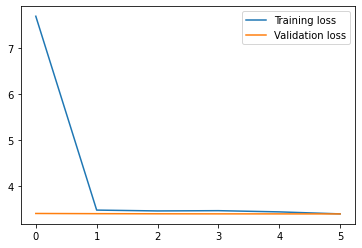

In [ ]:
#make the training and validation loss plot
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()

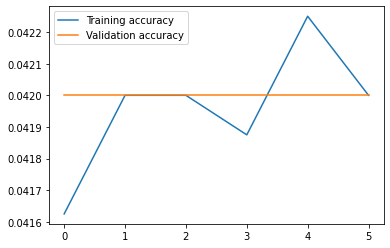

In [ ]:
#make the training and validation accuracy plot
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()

In [ ]:
round( max(history.history["val_accuracy"]), 3)

0.042

# Build Convolutional NN

In [ ]:
data_augmentation = keras.Sequential(
            [
               layers.RandomFlip("horizontal"),
               layers.RandomRotation(0.1),
               layers.RandomZoom(0.1),
] )

Let's add this step to our model and see if it helps performance!

In [ ]:

#define all the layers of the model
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) #added data augmentation
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)       #with both these layers included the NN is too deep and gets caught at val_accuraccy=0.042 
#x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(30, activation="softmax")(x)

#build the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Let's fit this new model

In [ ]:
#set the early stopping and model saving
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="Convnet_max_tools.keras",
    save_best_only=True,
    monitor="val_loss"),
    
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5)
]

#fit the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
200/200 [==============================] - 67s 257ms/step - loss: 2.8254 - accuracy: 0.1954 - val_loss: 2.6651 - val_accuracy: 0.3100
Epoch 2/30
200/200 [==============================] - 49s 240ms/step - loss: 1.9787 - accuracy: 0.4089 - val_loss: 1.6489 - val_accuracy: 0.5010
Epoch 3/30
200/200 [==============================] - 46s 220ms/step - loss: 1.6638 - accuracy: 0.5010 - val_loss: 1.8288 - val_accuracy: 0.4580
Epoch 4/30
200/200 [==============================] - 46s 225ms/step - loss: 1.4585 - accuracy: 0.5570 - val_loss: 1.8347 - val_accuracy: 0.5360
Epoch 5/30
200/200 [==============================] - 54s 265ms/step - loss: 1.3347 - accuracy: 0.5985 - val_loss: 1.4920 - val_accuracy: 0.5750
Epoch 6/30
200/200 [==============================] - 46s 221ms/step - loss: 1.2062 - accuracy: 0.6399 - val_loss: 1.1246 - val_accuracy: 0.6590
Epoch 7/30
200/200 [==============================] - 49s 240ms/step - loss: 1.0901 - accuracy: 0.6668 - val_loss: 0.9803 - val_ac

Let's see how the model fit.

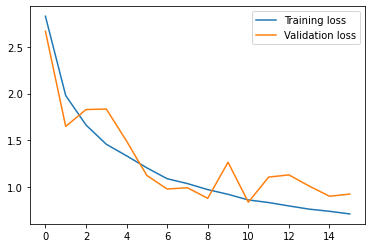

In [ ]:
#make the training and validation loss plot
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()

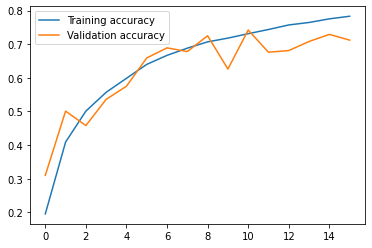

In [ ]:
#make the training and validation accuracy plot
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()

In [ ]:
round( max(history.history["val_accuracy"]), 3)

0.742

## <font color='lightblue'>Pretrained Model</font>


In [ ]:
#load a pretreined model
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
print(conv_base.summary() )

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
#Set all the weights to non-trainable
conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x) #this prepairs the data for vgg16
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(30, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_vgg16.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5)
]

In [ ]:
history = model.fit(
            train_dataset,
            epochs=50,
            validation_data=validation_dataset,
            callbacks=callbacks)

Epoch 1/50
200/200 [==============================] - 54s 240ms/step - loss: 24.0240 - accuracy: 0.6384 - val_loss: 15.3781 - val_accuracy: 0.8030
Epoch 2/50
200/200 [==============================] - 48s 234ms/step - loss: 14.8056 - accuracy: 0.7778 - val_loss: 16.2275 - val_accuracy: 0.8300
Epoch 3/50
200/200 [==============================] - 48s 233ms/step - loss: 12.6030 - accuracy: 0.8185 - val_loss: 12.4591 - val_accuracy: 0.8650
Epoch 4/50
200/200 [==============================] - 49s 233ms/step - loss: 11.3340 - accuracy: 0.8426 - val_loss: 16.6035 - val_accuracy: 0.8440
Epoch 5/50
200/200 [==============================] - 50s 241ms/step - loss: 9.9866 - accuracy: 0.8583 - val_loss: 12.1053 - val_accuracy: 0.8440
Epoch 6/50
200/200 [==============================] - 48s 235ms/step - loss: 9.3348 - accuracy: 0.8649 - val_loss: 11.9100 - val_accuracy: 0.8750
Epoch 7/50
200/200 [==============================] - 50s 243ms/step - loss: 8.6880 - accuracy: 0.8795 - val_loss: 11.33

KeyboardInterrupt: ignored

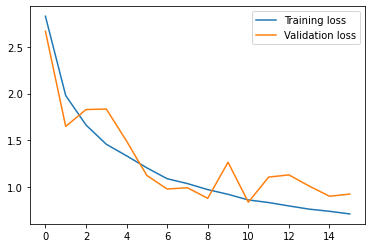

In [ ]:
#make the training and validation loss plot
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()

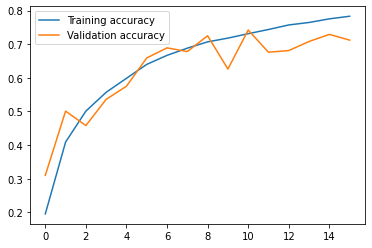

In [ ]:
#make the training and validation accuracy plot
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()

In [ ]:
round( max(history.history["val_accuracy"]), 3)

0.742



## <font color='lightblue'>Test and Explore our Best Model</font>

In [ ]:
model = keras.models.load_model("feature_extraction_with_vgg16.keras")

model.evaluate(test_dataset)

1000/1000 [==============================] - 16s 15ms/step - loss: 14.8300 - accuracy: 0.8660


[14.830024719238281, 0.8659999966621399]

Without full training of our VGG model we still achieve 86.5% accuracy.

In [ ]:
img_path = keras.utils.get_file(
    fname="baseballfield_10.jpg",
    origin="/content/split_data/val/BaseballField/baseballfield_10.jpg")

ValueError: ignored

In [ ]:
#make the image fit into the model
def get_img_array(img_path, target_size): 
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img) 
  array = np.expand_dims(array, axis=0) 
  return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

import matplotlib.pyplot as plt 

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8")) 
plt.show()

In [ ]:
model_viz.layers

In [ ]:
depth = 11

In [ ]:
activation_model = keras.Model(inputs=model_viz.inputs, outputs=model_viz.layers[depth].output)

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]

In [ ]:
print(first_layer_activation.shape)

In [ ]:
import matplotlib.pyplot as plt 
plt.matshow(first_layer_activation[:, :, 12], cmap="viridis")

Can we see some of the edge detection?

In [ ]:
train_ds = validation_dataset.unbatch()
images = np.asarray(list(validation_dataset.map(lambda x, y: x)))
labels = np.asarray(list(validation_dataset.map(lambda x, y: y)))

In [ ]:
!pip install shap -U
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 32.4 MB/s 


In [ ]:
# Build explainer to help explain predictions of the model
explainer = shap.GradientExplainer(model_viz, images[1,:,:,:,:])

# compute shap values
shap_values = explainer.shap_values(images[1,:,:,:,:])


NameError: ignored

In [ ]:
# plot SHAP values
shap.image_plot(shap_values,images[1,20:21,:,:,:]/255)

## <font color='lightblue'>Discussion</font>

###*Compare* the results of the dense and convolutional approach to model building. 

> Q7. Does one model outperform the other? (Marks: 1)

The dense model was only able to return an accuracy of 4%. With 30 classes random selection would result in 3%. As the validation accuracy didn't change with epoch as trained it is assumed the model is failing to train properly. The issue is likely a result of the flatten layer not passing the data in a shape the model expects. 

The convolutional model, without VGG trasnfered learning, had a maximum validation accuracy score of 80%. This model utilized data augmentation, as well as a dropout layer. The AID researchers reported an overall acuraccy of 89.64% using VGG-VD-16, when training on 50% of the dataset.

###Justify your choice of model architecture for the convolutional neural network (Marks:4)

> **Q3: Why did you choose the types of layers you did?**

A data augmentation layer was added at the beginning of the neural net in hopes of avoiding the model learning unwanted patterns. By scaling and rotating random images we can introduce stochasticity. This helps ensure the model only learns patterns that are caused by image artifacts. After the data augmentation layer we scale all our RGB values to be between 0 and 1. This reduces computational load and improves model performance. A series of Conv2D and MaxPooling layers were then added to create an expanding hypothesis space. The separableConv2D layer was originally implemented but reduced acuraccy by ~4%. This lets us infer that some correlation between colour layers is useful for predicting landscape and scenery. 

One attempt was made to create a deeper net, which used 512 filter Conv2D layer. This created issues with back propagation causing the model to not be able to train over 4%. This depth may be possible with added residual connections, but no solution could be found that warranted the added complexity. 

> **Q4: Why did you choose the size of layers you did?**

Early in the architecture we want our model to learn fewer filters, increasing in number as we go deep into the model. This helps expand the patterns the model identifies, starting with small edges and curve and ending with defined shapes. 

> **Q5: Why did you organize the layers the way you did?**

Each layer has a growing number of filters to learn higher level patterns. After each Conv2D layer a MaxPooling layer is used to reduce the spatial dimension of the output volume. Kernel size was set to 3, resulting in a 3x3 pixel filter for each layer.

 With more computational power it would be of interest to run the images uncompressed, 600x600, and larger filters to see how results vary. The intuition behind this is that many of the buildings and natural features are large in respect to the 600x600 pixel image, thus requiring larger filters to be recognized. To do this the first layer would be set to a kernel size of 7, the second layer set to 5, and all following layers set to 3.

> **Q6: Why did you choose the output layer size and activation function that you did?**

As we are trying to predict the probability that an image falls into a certain classification "softmax" was chosen. We used 30 nodes at the output layer, one corresponding to each class.

## <font color='lightblue'>Citations</font>
AID: A Benchmark Dataset for Performance Evaluation of Aerial Scene Classification
Gui-Song Xia1, Jingwen Hu1,2, Fan Hu1,2, Baoguang Shi3, Xiang Bai3, Yanfei Zhong1, Liangpei Zhang1

1. State Key Lab. LIESMARS, Wuhan University, Wuhan 430079, China
2. EIS, Wuhan University, Wuhan, 430079, China
3. EIC, Huazhong University of Science and Technology, Wuhan 430074, China.

published on IEEE Trans. on Geoscience and Remote Sensing, Vol. 55, No.7, pp.3965 - 3981, 2017.
https://captain-whu.github.io/AID/